# Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 500)

% matplotlib inline

Using TensorFlow backend.


## Data Preparation
There are too many observations in the dataset, which will take hours or even days to fit for some sophisticated algorithms. Thus, we decided to take a stratified sample on year of raw dataset in the model fitting stage. 

In [2]:
df_fe = pd.read_csv("data/output_fe.csv")
print("Shape of the raw input file: {}".format(df_fe.shape))

Shape of the raw input file: (95765, 196)


In [3]:
df_clean = df_fe.copy(deep=True)
df_clean = df_fe.groupby('year', group_keys=False).apply(lambda x: x.sample(frac=0.05, random_state=99))
df_clean.drop(['year'], axis=1, inplace=True)

print("Shape of the clean input file: {}".format(df_clean.shape))

Shape of the clean input file: (4789, 195)


### Stratified Sampling
We split training  and test dataset by stratifing on the response variable.

In [4]:
df_train, df_test = train_test_split(df_clean, 
                                     test_size = .5, 
                                     stratify = df_clean['response'], 
                                     random_state=90)

print("Shape of the training set: {}".format(df_train.shape))
print("Shape of the test set: {}".format(df_test.shape))

Shape of the training set: (2394, 195)
Shape of the test set: (2395, 195)


In [5]:
def split_columns(df, target_col, drop_columns):
    # Get the response variable
    y_train = df[[target_col]]

    # Drop the required columns
    X_train = df.drop(drop_columns, axis=1)
    
    return X_train, y_train

In [6]:
X_train, y_train = split_columns(df_train, target_col='response', drop_columns=['response'])
X_test, y_test = split_columns(df_test, target_col='response', drop_columns=['response'])

### Standardization
We standardize all the predictors that are not dummy variables. 

In [7]:
def scale_datasets(train_data, test_data, cols_to_scale):
    train = train_data.copy()
    test = test_data.copy()
    
    # Fit the scaler on the training data
    scaler = StandardScaler().fit(train[cols_to_scale])

    # Scale both the test and training data. 
    train[cols_to_scale] = scaler.transform(train[cols_to_scale])
    test[cols_to_scale] = scaler.transform(test[cols_to_scale])
    
    return train, test

In [8]:
X_train, X_test = scale_datasets(X_train, X_test, list(X_train.columns))

### Custom Functions 

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          fontsize=16):
    """
    This function plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=fontsize)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=fontsize)
    plt.yticks(tick_marks, classes, fontsize=fontsize)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=fontsize)

    plt.ylabel('True label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)
    plt.tight_layout()

## Classification of Good and Bad Loans

### Baseline Model
For classification, a simple baseline is always predicting the most common class, which is good loans in our dataset. 

In [10]:
base_train_acc = y_train.response.value_counts()[0] / len(y_train)
base_test_acc = y_test.response.value_counts()[0] / len(y_test)
print("Baseline model accuracy in training set: {:.2%}".format(base_train_acc))
print("Baseline model accuracy in test set: {:.2%}".format(base_test_acc))

Baseline model accuracy in training set: 84.17%
Baseline model accuracy in test set: 84.18%


### Oversampling 
As we can see from the baseline model accuracy, the lending club dataset is an imbalanced one with 84% of majority class and only 16% minority class. A common problem with imbalanced dataset is that the model will simply predict the majority class with a high accuracy score and ignore the minority class. However, accuracy or precision may not be the only concern we have as data scientists. 

For example, if we were building a model for cancer detection, we would want to capture all the patients that do have cancer, even at the cost of some misclassification of heathy people, as these people can be examined futher by doctors. As investors on lending club, what we really care about is the default risk. The key question we need to ask ourselves is that among all the bad loans, how many of them we can predict correctly? This is the so called recall rate.

Oversampling is a technique that can deal with this imbalanced dataset. The basic idea is to over sample the minority class,  so that the model can achieve higher recall at the cost of precision, and that's exactly what we want. In the modeling stage, We used Synthetic Minority Oversampling Technique (SMOTE) to oversample the training set. 

In [11]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
print("Oversampled Training Set:\nNumber of bad loans: {}\nNumber of good loans: {}".format(
    np.count_nonzero(y_train_sm == 1), np.count_nonzero(y_train_sm == 0))  
)

Oversampled Training Set:
Number of bad loans: 2015
Number of good loans: 2015


### Logistic Regression 

<b> Raw training set </b>

In [12]:
# Raw training set
logit = LogisticRegressionCV(cv=5, random_state=0, penalty='l2').fit(X_train, y_train)

train_acc = logit.score(X_train, y_train)
test_acc = logit.score(X_test, y_test)
report_lr = precision_recall_fscore_support(y_test, logit.predict(X_test), average='binary')

logit_results = {
    'model': 'Logistic',
    'train_acc': train_acc,
    'test_acc': test_acc,
    'precesion': report_lr[0],
    'recall': report_lr[1],
    'F1': report_lr[2]
}

print('Logistic Regression: accuracy on train={:.2%}, test={:.2%}, precision={:.2f}, recall={:.2f}, F1={:.2f}'.
      format(logit_results['train_acc'], 
             logit_results['test_acc'], 
             logit_results['precesion'], 
             logit_results['recall'], 
             logit_results['F1']))

Logistic Regression: accuracy on train=84.34%, test=84.13%, precision=0.40, recall=0.01, F1=0.01


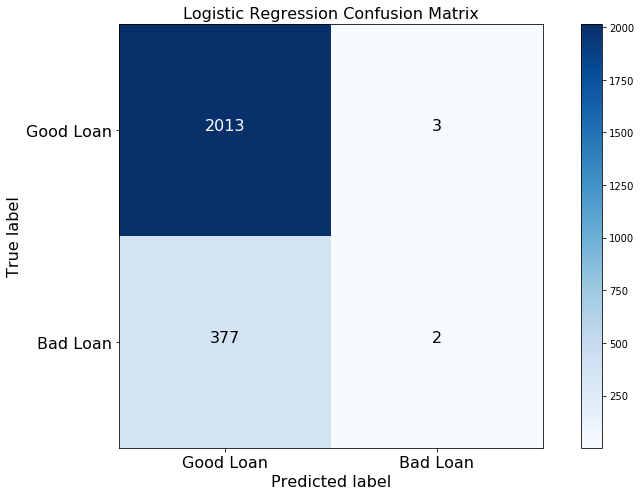

In [13]:
# Plot confusion matrix
cnf_matrix = confusion_matrix(y_test, logit.predict(X_test))
np.set_printoptions(precision=2)

plt.figure(figsize=(11,7))
plot_confusion_matrix(cnf_matrix, classes=["Good Loan", "Bad Loan"], normalize=False,
                      title='Logistic Regression Confusion Matrix')

plt.show()

<b> Oversampled Training set </b>

In [14]:
# SMOTE training set
logit_sm = LogisticRegressionCV(cv=5, random_state=0, penalty='l2').fit(X_train_sm, y_train_sm)

train_acc, test_acc = logit_sm.score(X_train_sm, y_train_sm), logit_sm.score(X_test, y_test)
report_lr = precision_recall_fscore_support(y_test, logit_sm.predict(X_test), average='binary')

logit_sm_results = {
    'model': 'Logistic',
    'train_acc': train_acc,
    'test_acc': test_acc,
    'precesion': report_lr[0],
    'recall': report_lr[1],
    'F1': report_lr[2]
}

print('Logistic Regression: accuracy on train={:.2%}, test={:.2%}, precision={:.2f}, recall={:.2f}, F1={:.2f}'.
      format(logit_sm_results['train_acc'], 
             logit_sm_results['test_acc'], 
             logit_sm_results['precesion'], 
             logit_sm_results['recall'], 
             logit_sm_results['F1']))

Logistic Regression: accuracy on train=73.05%, test=64.05%, precision=0.23, recall=0.54, F1=0.32


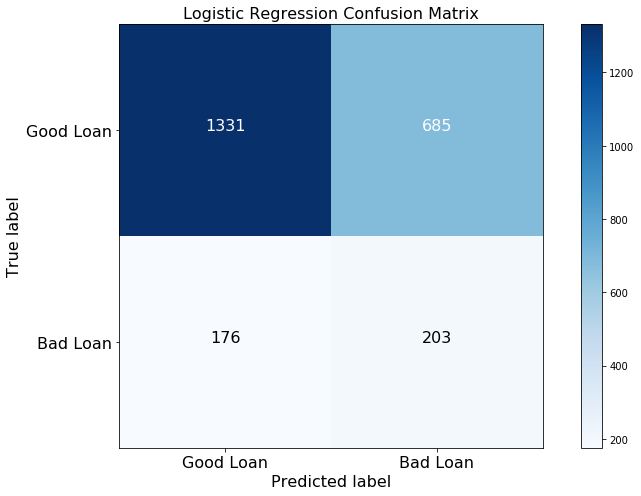

In [15]:
# Plot confusion matrix
cnf_matrix = confusion_matrix(y_test, logit_sm.predict(X_test))
np.set_printoptions(precision=2)

plt.figure(figsize=(11,7))
plot_confusion_matrix(cnf_matrix, classes=["Good Loan", "Bad Loan"], normalize=False,
                      title='Logistic Regression Confusion Matrix')

plt.show()

### kNN 

<b> Raw training set </b>

In [16]:
max_score = 0
max_k = 0 
scores = []

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors = k)
    score = cross_val_score(knn, X_train, y_train, cv=5).mean()
    
    scores.append(score)
    if score > max_score:
        max_k = k
        max_score = score
        
scores = pd.DataFrame({'k': range(1, 21), 'accuracy': scores})

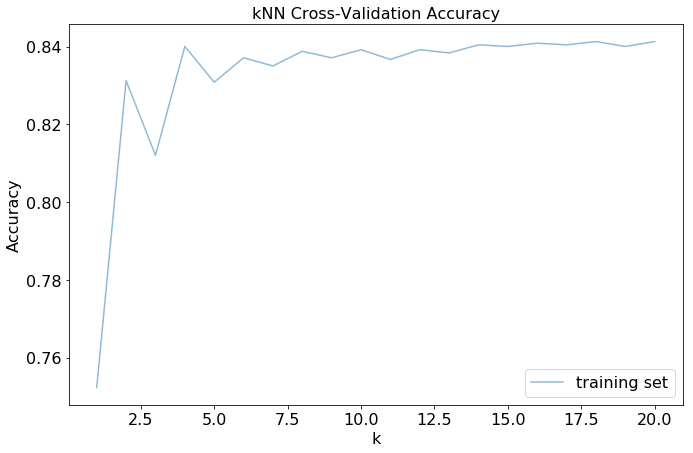

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(11, 7))
ax.plot(scores['k'], scores['accuracy'], alpha=0.5, label='training set')  
ax.set_title('kNN Cross-Validation Accuracy', fontsize=16)
ax.set_xlabel('k', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.legend(fontsize=16)
ax.tick_params(labelsize=16)
plt.show()

In [18]:
knn = KNeighborsClassifier(n_neighbors = max_k)
knn.fit(X_train, y_train)

train_acc, test_acc = knn.score(X_train, y_train), knn.score(X_test, y_test)

print('kNN: Optimal k={}'.format(max_k))

report_lr = precision_recall_fscore_support(y_test, knn.predict(X_test), average='binary')

knn_results = {
    'model': 'kNN',
    'train_acc': train_acc,
    'test_acc': test_acc,
    'precesion': report_lr[0],
    'recall': report_lr[1],
    'F1': report_lr[2]
}

print('kNN: accuracy on train={:.2%}, test={:.2%}, precision={:.2f}, recall={:.2f}, F1={:.2f}'.
      format(knn_results['train_acc'], 
             knn_results['test_acc'], 
             knn_results['precesion'], 
             knn_results['recall'], 
             knn_results['F1']))

kNN: Optimal k=18
kNN: accuracy on train=84.21%, test=84.05%, precision=0.00, recall=0.00, F1=0.00


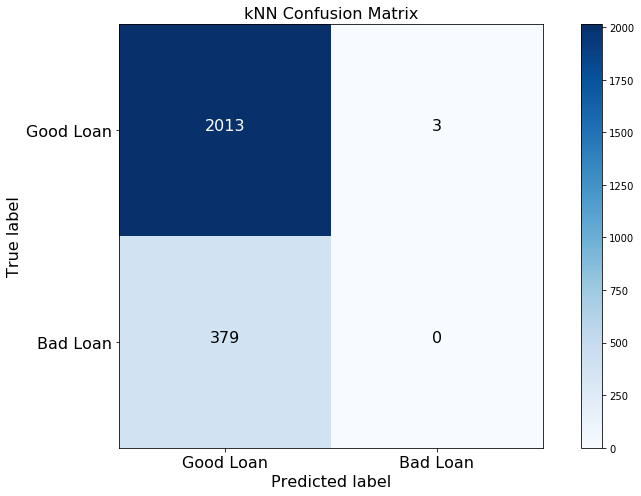

In [19]:
cnf_matrix = confusion_matrix(y_test, knn.predict(X_test))
np.set_printoptions(precision=2)

plt.figure(figsize=(11,7))
plot_confusion_matrix(cnf_matrix, classes=["Good Loan", "Bad Loan"], normalize=False,
                      title='kNN Confusion Matrix')

plt.show()

<b> Oversampled Training set </b>

In [20]:
max_score = 0
max_k = 0 
scores = []

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors = k)
    score = cross_val_score(knn, X_train_sm, y_train_sm, cv=5).mean()
    
    scores.append(score)
    if score > max_score:
        max_k = k
        max_score = score
        
scores = pd.DataFrame({'k': range(1, 21), 'accuracy': scores})

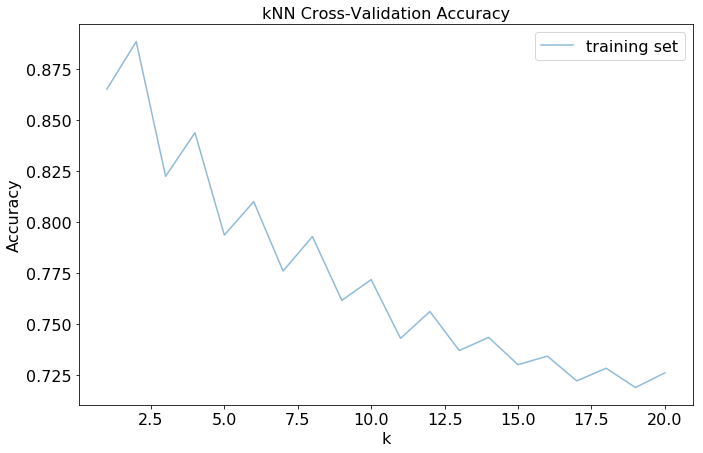

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(11, 7))
ax.plot(scores['k'], scores['accuracy'], alpha=0.5, label='training set')  
ax.set_title('kNN Cross-Validation Accuracy', fontsize=16)
ax.set_xlabel('k', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.legend(fontsize=16)
ax.tick_params(labelsize=16)
plt.show()

In [22]:
knn_sm = KNeighborsClassifier(n_neighbors = max_k)
knn_sm.fit(X_train_sm, y_train_sm)

train_acc, test_acc = knn_sm.score(X_train_sm, y_train_sm), knn_sm.score(X_test, y_test)

print('kNN: Optimal k={}'.format(max_k))

report_lr = precision_recall_fscore_support(y_test, knn_sm.predict(X_test), average='binary')

knn_sm_results = {
    'model': 'kNN',
    'train_acc': train_acc,
    'test_acc': test_acc,
    'precesion': report_lr[0],
    'recall': report_lr[1],
    'F1': report_lr[2]
}

print('kNN: accuracy on train={:.2%}, test={:.2%}, precision={:.2f}, recall={:.2f}, F1={:.2f}'.
      format(knn_sm_results['train_acc'], 
             knn_sm_results['test_acc'], 
             knn_sm_results['precesion'], 
             knn_sm_results['recall'], 
             knn_sm_results['F1']))

kNN: Optimal k=2
kNN: accuracy on train=99.80%, test=72.28%, precision=0.21, recall=0.28, F1=0.24


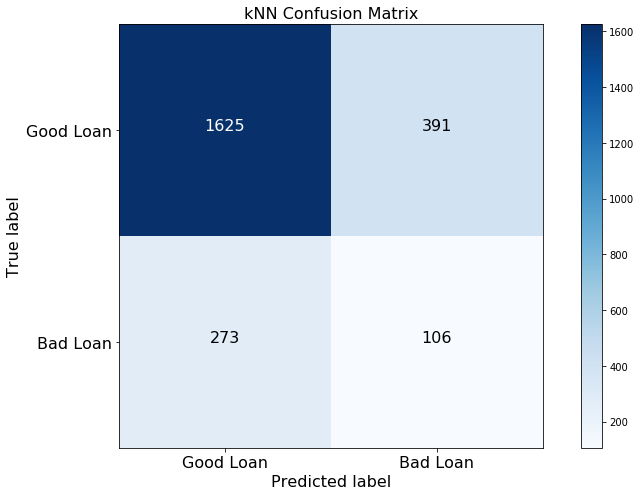

In [23]:
cnf_matrix = confusion_matrix(y_test, knn_sm.predict(X_test))
np.set_printoptions(precision=2)

plt.figure(figsize=(11,7))
plot_confusion_matrix(cnf_matrix, classes=["Good Loan", "Bad Loan"], normalize=False,
                      title='kNN Confusion Matrix')

plt.show()

### LDA

<b> Raw training set </b>

In [24]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

train_acc, test_acc = lda.score(X_train, y_train), lda.score(X_test, y_test)
report_lr = precision_recall_fscore_support(y_test, lda.predict(X_test), average='binary')

lda_results = {
    'model': 'LDA',
    'train_acc': train_acc,
    'test_acc': test_acc,
    'precesion': report_lr[0],
    'recall': report_lr[1],
    'F1': report_lr[2]
}

print('LDA: accuracy on train={:.2%}, test={:.2%}, precision={:.2f}, recall={:.2f}, F1={:.2f}'.
      format(lda_results['train_acc'], 
             lda_results['test_acc'], 
             lda_results['precesion'], 
             lda_results['recall'], 
             lda_results['F1']))

LDA: accuracy on train=85.13%, test=82.21%, precision=0.36, recall=0.15, F1=0.21


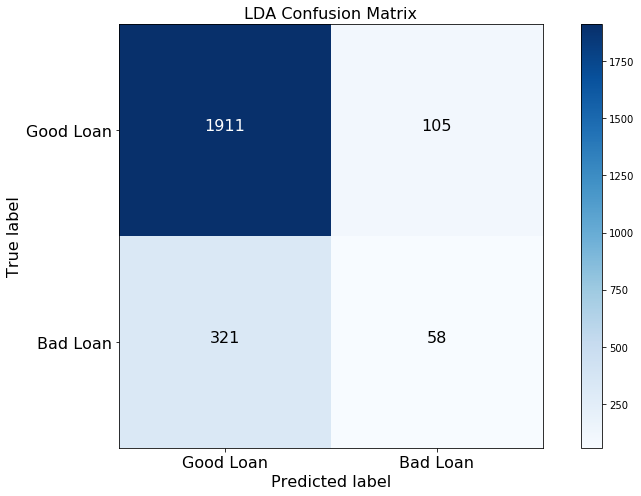

In [25]:
cnf_matrix = confusion_matrix(y_test, lda.predict(X_test))
np.set_printoptions(precision=2)

plt.figure(figsize=(11,7))
plot_confusion_matrix(cnf_matrix, classes=["Good Loan", "Bad Loan"], normalize=False,
                      title='LDA Confusion Matrix')

plt.show()

<b> Oversampled Training set </b>

In [26]:
lda_sm = LinearDiscriminantAnalysis()
lda_sm.fit(X_train_sm, y_train_sm)

train_acc, test_acc = lda_sm.score(X_train_sm, y_train_sm), lda_sm.score(X_test, y_test)
report_lr = precision_recall_fscore_support(y_test, lda_sm.predict(X_test), average='binary')

lda_sm_results = {
    'model': 'LDA',
    'train_acc': train_acc,
    'test_acc': test_acc,
    'precesion': report_lr[0],
    'recall': report_lr[1],
    'F1': report_lr[2]
}

print('LDA: accuracy on train={:.2%}, test={:.2%}, precision={:.2f}, recall={:.2f}, F1={:.2f}'.
      format(lda_sm_results['train_acc'], 
             lda_sm_results['test_acc'], 
             lda_sm_results['precesion'], 
             lda_sm_results['recall'], 
             lda_sm_results['F1']))

LDA: accuracy on train=72.61%, test=64.22%, precision=0.23, recall=0.53, F1=0.32


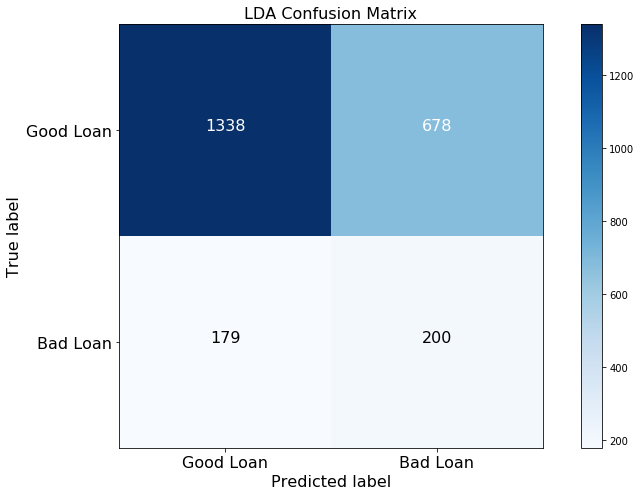

In [27]:
cnf_matrix = confusion_matrix(y_test, lda_sm.predict(X_test))
np.set_printoptions(precision=2)

plt.figure(figsize=(11,7))
plot_confusion_matrix(cnf_matrix, classes=["Good Loan", "Bad Loan"], normalize=False,
                      title='LDA Confusion Matrix')

plt.show()

### QDA

<b> Raw training set </b>

In [28]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

train_acc, test_acc = qda.score(X_train, y_train), qda.score(X_test, y_test)
report_lr = precision_recall_fscore_support(y_test, qda.predict(X_test), average='binary')

qda_results = {
    'model': 'QDA',
    'train_acc': train_acc,
    'test_acc': test_acc,
    'precesion': report_lr[0],
    'recall': report_lr[1],
    'F1': report_lr[2]
}

print('LDA: accuracy on train={:.2%}, test={:.2%}, precision={:.2f}, recall={:.2f}, F1={:.2f}'.
      format(qda_results['train_acc'], 
             qda_results['test_acc'], 
             qda_results['precesion'], 
             qda_results['recall'], 
             qda_results['F1']))

LDA: accuracy on train=53.63%, test=45.85%, precision=0.18, recall=0.66, F1=0.28


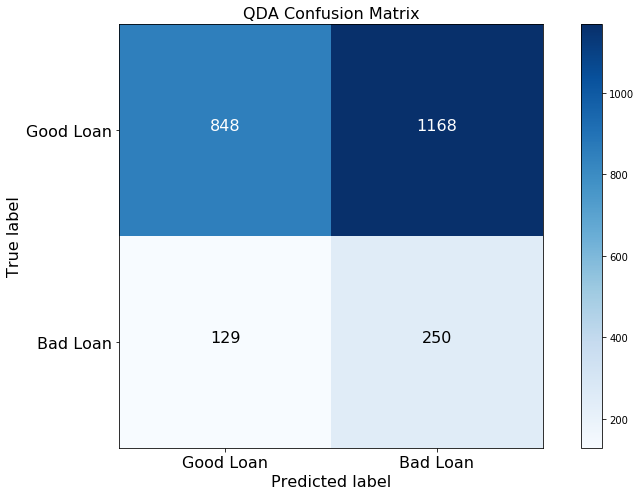

In [29]:
cnf_matrix = confusion_matrix(y_test, qda.predict(X_test))
np.set_printoptions(precision=2)

plt.figure(figsize=(11,7))
plot_confusion_matrix(cnf_matrix, classes=["Good Loan", "Bad Loan"], normalize=False,
                      title='QDA Confusion Matrix')

plt.show()

<b> Oversampled Training set </b>

In [30]:
qda_sm = QuadraticDiscriminantAnalysis()
qda_sm.fit(X_train_sm, y_train_sm)

train_acc, test_acc = qda_sm.score(X_train_sm, y_train_sm), qda_sm.score(X_test, y_test)
report_lr = precision_recall_fscore_support(y_test, qda_sm.predict(X_test), average='binary')

qda_sm_results = {
    'model': 'QDA',
    'train_acc': train_acc,
    'test_acc': test_acc,
    'precesion': report_lr[0],
    'recall': report_lr[1],
    'F1': report_lr[2]
}

print('LDA: accuracy on train={:.2%}, test={:.2%}, precision={:.2f}, recall={:.2f}, F1={:.2f}'.
      format(qda_sm_results['train_acc'], 
             qda_sm_results['test_acc'], 
             qda_sm_results['precesion'], 
             qda_sm_results['recall'], 
             qda_sm_results['F1']))

LDA: accuracy on train=76.72%, test=53.32%, precision=0.17, recall=0.51, F1=0.26


### Single Decision Tree

<b> Raw training set </b>

In [31]:
train_scores = []
validation_scores = []
test_scores = []

best_score = 0
best_depth = 0 

depths = [i for i in range(2, 11)]

for depth in depths:
    tree = DecisionTreeClassifier(max_depth = depth)
    tree.fit(X_train, y_train)
    
    train_scores.append(tree.score(X_train, y_train))
    test_scores.append(tree.score(X_test, y_test))
    
    val_score = cross_val_score(estimator=tree, X=X_train, y=y_train, cv=5).mean()
    validation_scores.append(val_score)
    
    if val_score > best_score:
        best_depth = depth
        best_score = score

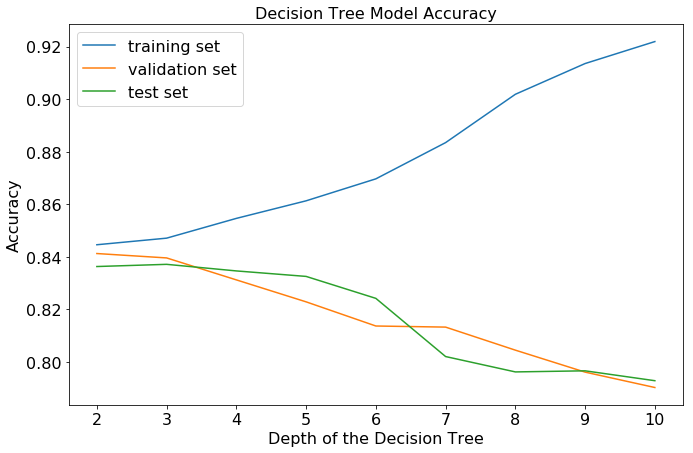

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(11, 7))
ax.plot(depths, train_scores, label='training set')  
ax.plot(depths, validation_scores, label='validation set')  
ax.plot(depths, test_scores, label='test set')  
ax.tick_params(labelsize=16)
ax.set_title('Decision Tree Model Accuracy', fontsize=16)
ax.set_xlabel('Depth of the Decision Tree', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.legend(fontsize=16)
plt.show()

In [33]:
tree = DecisionTreeClassifier(max_depth = best_depth)
tree.fit(X_train, y_train)

train_acc, test_acc = tree.score(X_train, y_train), tree.score(X_test, y_test)

print('Single Tree: Optimal depth={}'.format(best_depth))

report_lr = precision_recall_fscore_support(y_test, tree.predict(X_test), average='binary')

tree_results = {
    'model': 'Single Tree',
    'train_acc': train_acc,
    'test_acc': test_acc,
    'precesion': report_lr[0],
    'recall': report_lr[1],
    'F1': report_lr[2]
}

print('Signle Tree: accuracy on train={:.2%}, test={:.2%}, precision={:.2f}, recall={:.2f}, F1={:.2f}'.
      format(tree_results['train_acc'], 
             tree_results['test_acc'], 
             tree_results['precesion'], 
             tree_results['recall'], 
             tree_results['F1']))

Single Tree: Optimal depth=10
Signle Tree: accuracy on train=92.19%, test=79.16%, precision=0.23, recall=0.13, F1=0.17


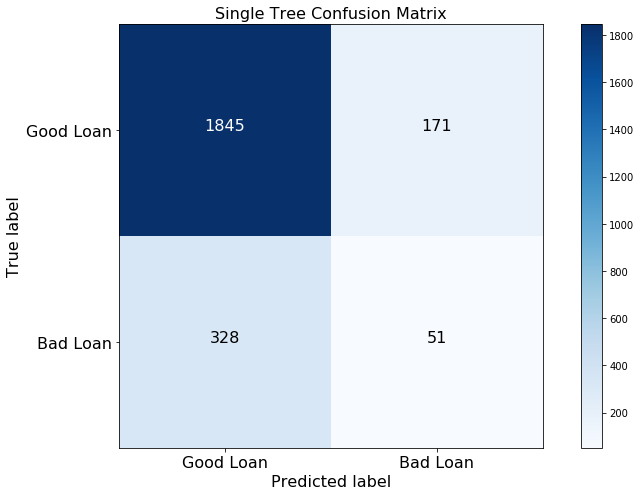

In [34]:
# Plot confusion matrix
y_pred = tree.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(11,7))
plot_confusion_matrix(cnf_matrix, classes=["Good Loan", "Bad Loan"], normalize=False,
                      title='Single Tree Confusion Matrix')

plt.show()

<b> Oversampled Training set </b>

In [35]:
train_scores = []
validation_scores = []
test_scores = []

best_score = 0
best_depth = 0 

depths = [i for i in range(2, 11)]

for depth in depths:
    tree = DecisionTreeClassifier(max_depth = depth)
    tree.fit(X_train_sm, y_train_sm)
    
    train_scores.append(tree.score(X_train_sm, y_train_sm))
    test_scores.append(tree.score(X_test, y_test))
    
    val_score = cross_val_score(estimator=tree, X=X_train_sm, y=y_train_sm, cv=5).mean()
    validation_scores.append(val_score)
    
    if val_score > best_score:
        best_depth = depth
        best_score = score

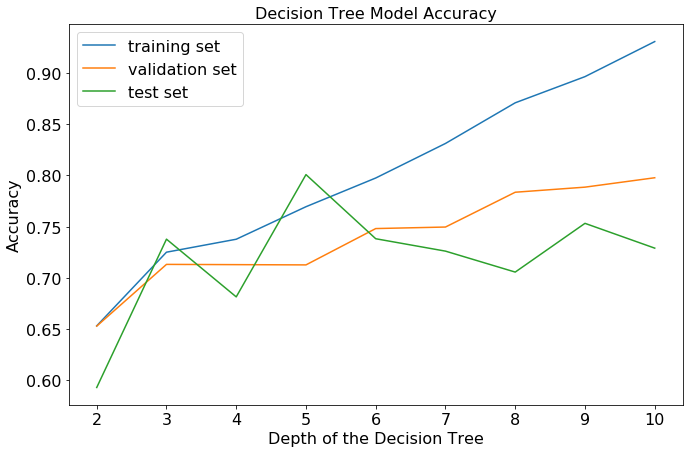

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(11, 7))
ax.plot(depths, train_scores, label='training set')  
ax.plot(depths, validation_scores, label='validation set')  
ax.plot(depths, test_scores, label='test set')  
ax.tick_params(labelsize=16)
ax.set_title('Decision Tree Model Accuracy', fontsize=16)
ax.set_xlabel('Depth of the Decision Tree', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.legend(fontsize=16)
plt.show()

In [37]:
tree_sm = DecisionTreeClassifier(max_depth = best_depth)
tree_sm.fit(X_train_sm, y_train_sm)

train_acc, test_acc = tree_sm.score(X_train_sm, y_train_sm), tree_sm.score(X_test, y_test)

print('Single Tree: Optimal depth={}'.format(best_depth))

report_lr = precision_recall_fscore_support(y_test, tree_sm.predict(X_test), average='binary')

tree_sm_results = {
    'model': 'Single Tree',
    'train_acc': train_acc,
    'test_acc': test_acc,
    'precesion': report_lr[0],
    'recall': report_lr[1],
    'F1': report_lr[2]
}

print('Single Tree: accuracy on train={:.2%}, test={:.2%}, precision={:.2f}, recall={:.2f}, F1={:.2f}'.
      format(tree_sm_results['train_acc'], 
             tree_sm_results['test_acc'], 
             tree_sm_results['precesion'], 
             tree_sm_results['recall'], 
             tree_sm_results['F1']))

Single Tree: Optimal depth=10
Single Tree: accuracy on train=93.05%, test=72.57%, precision=0.22, recall=0.30, F1=0.25


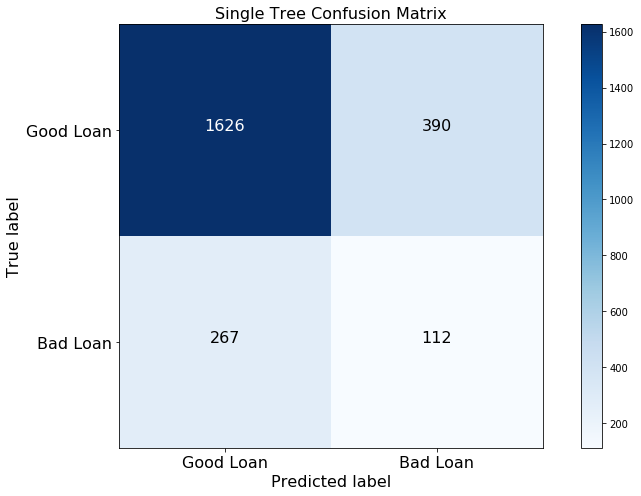

In [38]:
# Plot confusion matrix
y_pred = tree_sm.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(11,7))
plot_confusion_matrix(cnf_matrix, classes=["Good Loan", "Bad Loan"], normalize=False,
                      title='Single Tree Confusion Matrix')

plt.show()

### Random Forest

<b> Raw training set </b>

In [39]:
train_scores = []
validation_scores = []
test_scores = []

best_score = 0
best_depth = 0 

n_trees = 100
depths = [i for i in range(2, 21)]

for depth in depths:
    rf = RandomForestClassifier(n_estimators=n_trees, max_depth=depth, n_jobs=-1, random_state=90)
    rf.fit(X_train, y_train)
    
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    
    val_score = cross_val_score(estimator=rf, X=X_train, y=y_train, cv=5).mean()
    validation_scores.append(val_score)
    
    if val_score > best_score:
        best_depth = depth
        best_score = val_score

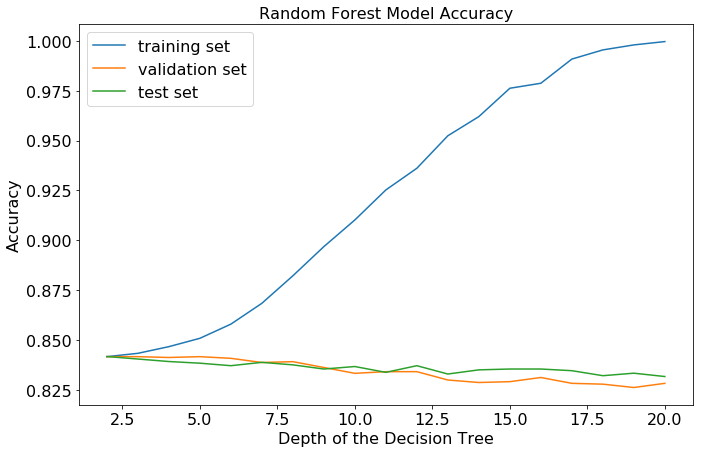

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(11, 7))
ax.plot(depths, train_scores, label='training set')  
ax.plot(depths, validation_scores, label='validation set')  
ax.plot(depths, test_scores, label='test set')  
ax.tick_params(labelsize=16)
ax.set_title('Random Forest Model Accuracy', fontsize=16)
ax.set_xlabel('Depth of the Decision Tree', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.legend(fontsize=16)
plt.show()

In [41]:
rf = RandomForestClassifier(n_estimators=n_trees, max_depth=best_depth, n_jobs=-1, random_state=90)
rf.fit(X_train, y_train)

train_acc, test_acc = rf.score(X_train, y_train), rf.score(X_test, y_test)

print('Random Forest: Optimal depth={}'.format(best_depth))

report_lr = precision_recall_fscore_support(y_test, rf.predict(X_test), average='binary')

rf_results = {
    'model': 'Random Forest',
    'train_acc': train_acc,
    'test_acc': test_acc,
    'precesion': report_lr[0],
    'recall': report_lr[1],
    'F1': report_lr[2]
}

print('Random Forest: accuracy on train={:.2%}, test={:.2%}, precision={:.2f}, recall={:.2f}, F1={:.2f}'.
      format(rf_results['train_acc'], 
             rf_results['test_acc'], 
             rf_results['precesion'], 
             rf_results['recall'], 
             rf_results['F1']))

Random Forest: Optimal depth=2
Random Forest: accuracy on train=84.17%, test=84.18%, precision=0.00, recall=0.00, F1=0.00


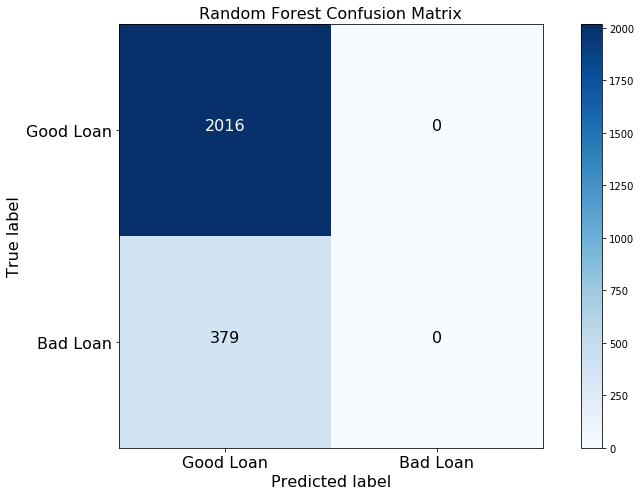

In [42]:
# Plot confusion matrix
y_pred = rf.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(11,7))
plot_confusion_matrix(cnf_matrix, classes=["Good Loan", "Bad Loan"], normalize=False,
                      title='Random Forest Confusion Matrix')

plt.show()

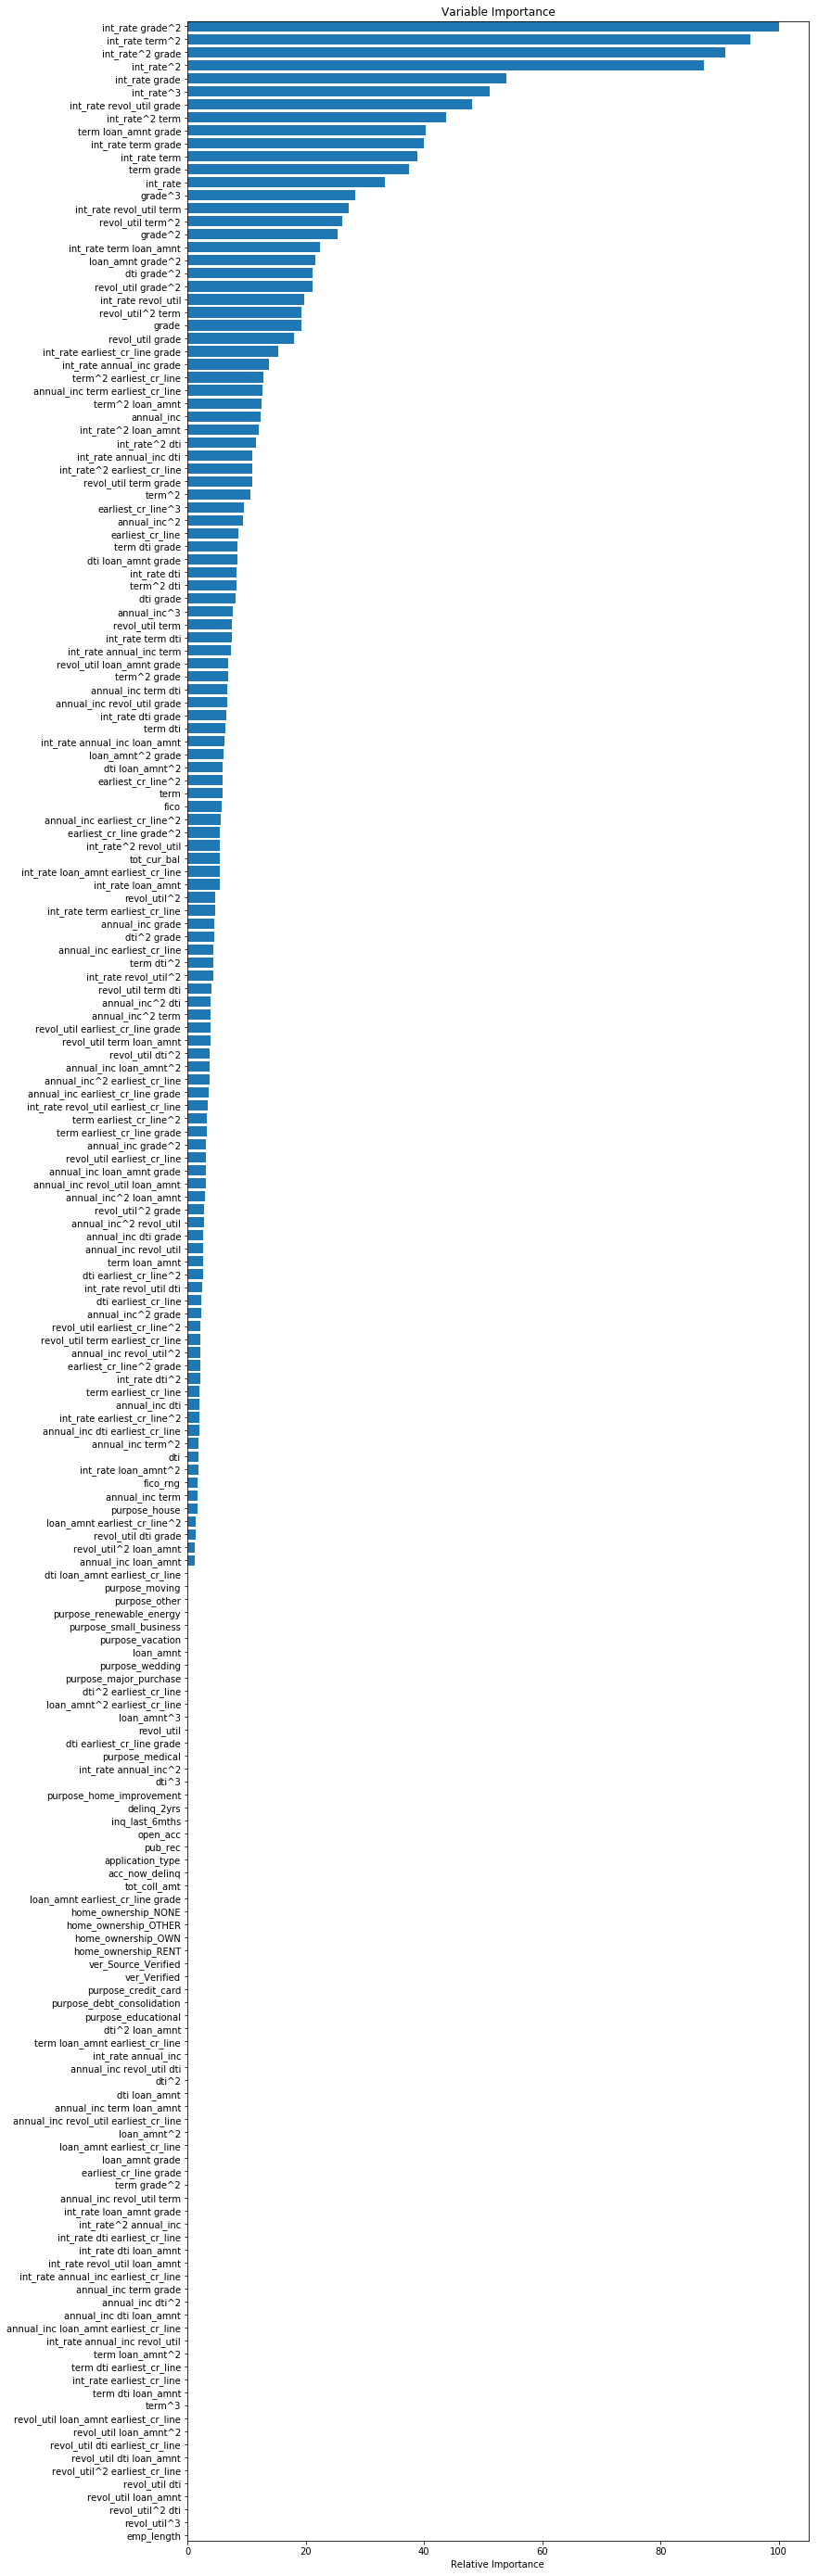

In [43]:
# Random Forest Feature Importance
feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])

# Plot
plt.figure(figsize=(12,50))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.margins(y=0)
plt.show()

<b> Oversampled Training set </b>

In [44]:
train_scores = []
validation_scores = []
test_scores = []

best_score = 0
best_depth = 0 

n_trees = 100
depths = [i for i in range(2, 21)]

for depth in depths:
    rf = RandomForestClassifier(n_estimators=n_trees, max_depth=depth, n_jobs=-1, random_state=90)
    rf.fit(X_train_sm, y_train_sm)
    
    train_scores.append(rf.score(X_train_sm, y_train_sm))
    test_scores.append(rf.score(X_test, y_test))
    
    val_score = cross_val_score(estimator=rf, X=X_train_sm, y=y_train_sm, cv=5).mean()
    validation_scores.append(val_score)
    
    if val_score > best_score:
        best_depth = depth
        best_score = val_score

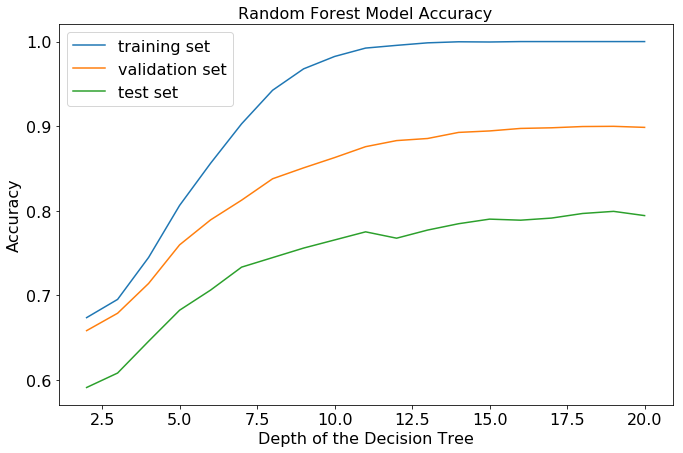

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(11, 7))
ax.plot(depths, train_scores, label='training set')  
ax.plot(depths, validation_scores, label='validation set')  
ax.plot(depths, test_scores, label='test set')  
ax.tick_params(labelsize=16)
ax.set_title('Random Forest Model Accuracy', fontsize=16)
ax.set_xlabel('Depth of the Decision Tree', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.legend(fontsize=16)
plt.show()

In [46]:
rf_sm = RandomForestClassifier(n_estimators=n_trees, max_depth=best_depth, n_jobs=-1, random_state=90)
rf_sm.fit(X_train_sm, y_train_sm)

train_acc, test_acc = rf_sm.score(X_train_sm, y_train_sm), rf_sm.score(X_test, y_test)

print('Random Forest: Optimal depth={}'.format(best_depth))

report_lr = precision_recall_fscore_support(y_test, rf_sm.predict(X_test), average='binary')

rf_sm_results = {
    'model': 'Random Forest',
    'train_acc': train_acc,
    'test_acc': test_acc,
    'precesion': report_lr[0],
    'recall': report_lr[1],
    'F1': report_lr[2]
}

print('Random Forest: accuracy on train={:.2%}, test={:.2%}, precision={:.2f}, recall={:.2f}, F1={:.2f}'.
      format(rf_sm_results['train_acc'], 
             rf_sm_results['test_acc'], 
             rf_sm_results['precesion'], 
             rf_sm_results['recall'], 
             rf_sm_results['F1']))

Random Forest: Optimal depth=19
Random Forest: accuracy on train=100.00%, test=79.92%, precision=0.30, recall=0.20, F1=0.24


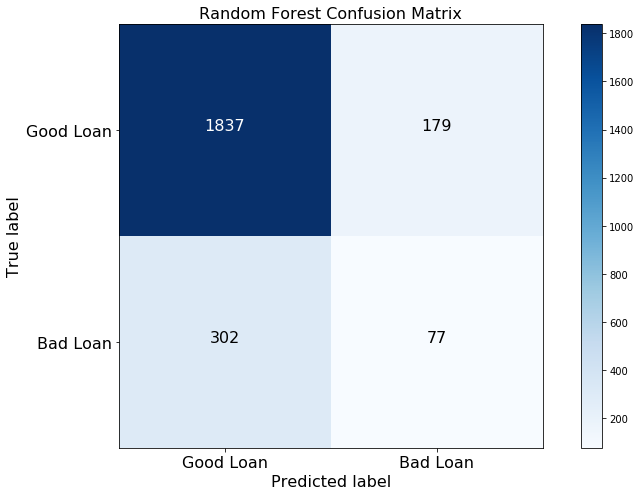

In [47]:
# Plot confusion matrix
y_pred = rf_sm.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(11,7))
plot_confusion_matrix(cnf_matrix, classes=["Good Loan", "Bad Loan"], normalize=False,
                      title='Random Forest Confusion Matrix')

plt.show()

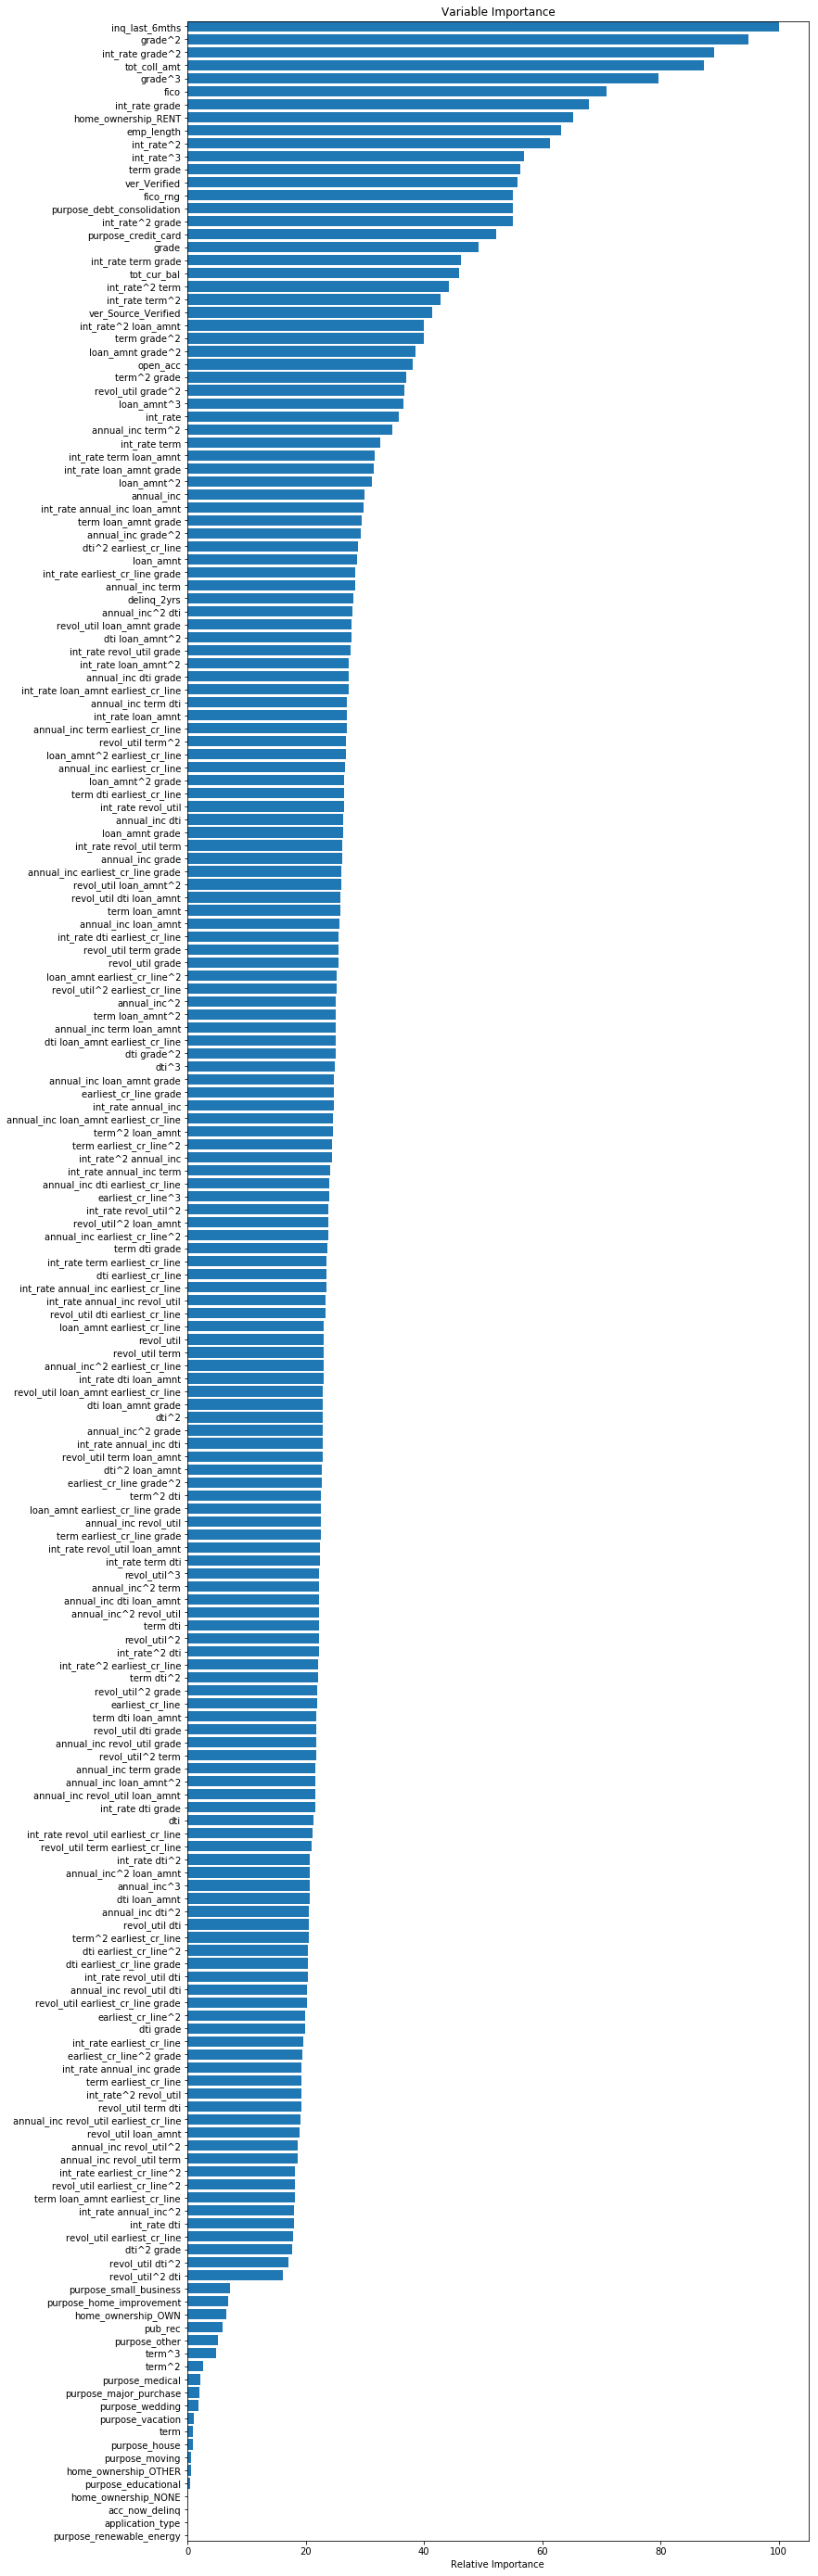

In [48]:
# Random Forest Feature Importance
feature_importance = rf_sm.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])

# Plot
plt.figure(figsize=(12,50))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.margins(y=0)
plt.show()

### AddBoost

<b> Raw training set </b>

In [49]:
estimators = [10, 20, 30, 40, 50]
depths = list(range(2, 5))

train_scores = pd.DataFrame(index=depths, columns=estimators)
validation_scores = pd.DataFrame(index=depths, columns=estimators)
test_scores = pd.DataFrame(index=depths, columns=estimators)

best_score = 0
best_depth = 0 
best_estimator = 0

for e in estimators:
    for d in depths: 
        ab = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=d), 
                                n_estimators=e, learning_rate=0.05)
        ab.fit(X_train, y_train)
        
        train_scores.loc[d, e] = ab.score(X_train, y_train)
        test_scores.loc[d, e] = ab.score(X_test, y_test)
        
        val_score = cross_val_score(estimator=ab, X=X_train, y=y_train, cv=5).mean()
        validation_scores.loc[d, e] = val_score
        
        if val_score > best_score:
            best_depth = d
            best_estimator = e
            best_score = val_score

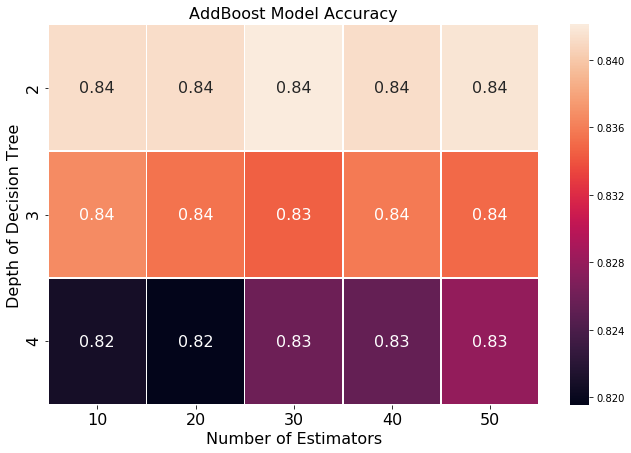

In [50]:
validation_scores = validation_scores.astype(float)

f, ax = plt.subplots(figsize=(11, 7))
sns.heatmap(validation_scores, annot=True, linewidths=.5, ax=ax, annot_kws={"size": 16})
ax.set_ylabel('Depth of Decision Tree', fontsize=16)
ax.set_xlabel('Number of Estimators', fontsize=16)
ax.set_title('AddBoost Model Accuracy', fontsize=16)
ax.tick_params(labelsize=16)

In [51]:
print('AddBoost: Optimal depth={}'.format(best_depth))
print('AddBoost: Optimal number of estimators={}'.format(best_estimator))

ab = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=best_depth), 
                        n_estimators=best_estimator, learning_rate=0.05)
ab.fit(X_train, y_train)

train_acc, test_acc = ab.score(X_train, y_train), ab.score(X_test, y_test)

report_lr = precision_recall_fscore_support(y_test, ab.predict(X_test), average='binary')

ab_results = {
    'model': 'AddBoost',
    'train_acc': train_acc,
    'test_acc': test_acc,
    'precesion': report_lr[0],
    'recall': report_lr[1],
    'F1': report_lr[2]
}

print('Random Forest: accuracy on train={:.2%}, test={:.2%}, precision={:.2f}, recall={:.2f}, F1={:.2f}'.
      format(ab_results['train_acc'], 
             ab_results['test_acc'], 
             ab_results['precesion'], 
             ab_results['recall'], 
             ab_results['F1']))

AddBoost: Optimal depth=2
AddBoost: Optimal number of estimators=30
Random Forest: accuracy on train=84.17%, test=84.18%, precision=0.00, recall=0.00, F1=0.00


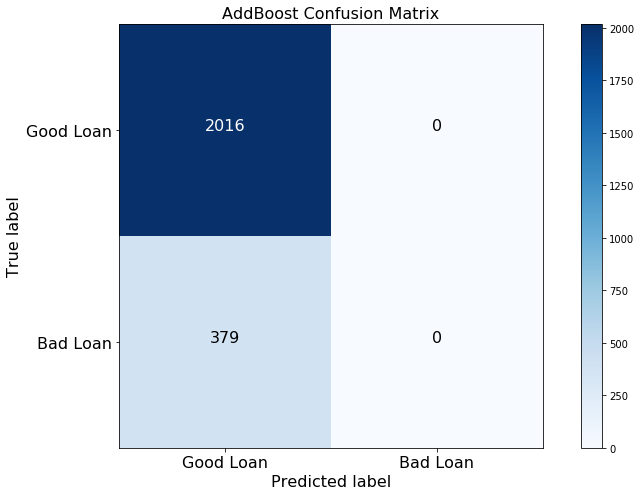

In [52]:
# Plot confusion matrix
y_pred = ab.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(11,7))
plot_confusion_matrix(cnf_matrix, classes=["Good Loan", "Bad Loan"], normalize=False,
                      title='AddBoost Confusion Matrix')

plt.show()

<b> Oversampled Training set </b>

In [53]:
estimators = [10, 20, 30, 40, 50]
depths = list(range(2, 5))

train_scores = pd.DataFrame(index=depths, columns=estimators)
validation_scores = pd.DataFrame(index=depths, columns=estimators)
test_scores = pd.DataFrame(index=depths, columns=estimators)

best_score = 0
best_depth = 0 
best_estimator = 0

for e in estimators:
    for d in depths: 
        ab = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=d), 
                                n_estimators=e, learning_rate=0.05)
        ab.fit(X_train_sm, y_train_sm)
        
        train_scores.loc[d, e] = ab.score(X_train_sm, y_train_sm)
        test_scores.loc[d, e] = ab.score(X_test, y_test)
        
        val_score = cross_val_score(estimator=ab, X=X_train_sm, y=y_train_sm, cv=5).mean()
        validation_scores.loc[d, e] = val_score
        
        if val_score > best_score:
            best_depth = d
            best_estimator = e
            best_score = val_score

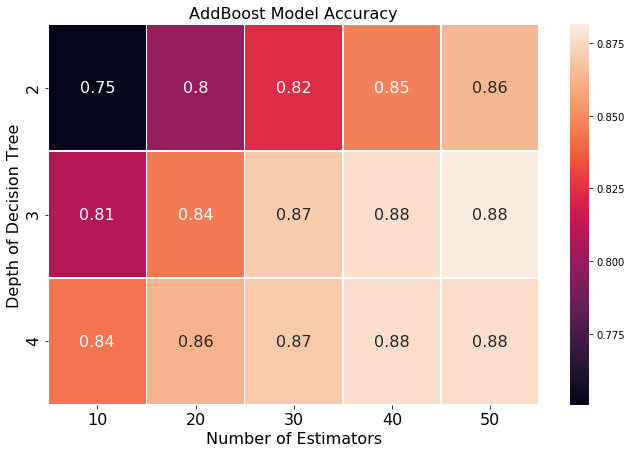

In [54]:
validation_scores = validation_scores.astype(float)

f, ax = plt.subplots(figsize=(11, 7))
sns.heatmap(validation_scores, annot=True, linewidths=.5, ax=ax, annot_kws={"size": 16})
ax.set_ylabel('Depth of Decision Tree', fontsize=16)
ax.set_xlabel('Number of Estimators', fontsize=16)
ax.set_title('AddBoost Model Accuracy', fontsize=16)
ax.tick_params(labelsize=16)

In [55]:
print('AddBoost: Optimal depth={}'.format(best_depth))
print('AddBoost: Optimal number of estimators={}'.format(best_estimator))

ab_sm = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=best_depth), 
                        n_estimators=best_estimator, learning_rate=0.05)
ab_sm.fit(X_train_sm, y_train_sm)

train_acc, test_acc = ab_sm.score(X_train_sm, y_train_sm), ab.score(X_test, y_test)

report_lr = precision_recall_fscore_support(y_test, ab_sm.predict(X_test), average='binary')

ab_sm_results = {
    'model': 'AddBoost',
    'train_acc': train_acc,
    'test_acc': test_acc,
    'precesion': report_lr[0],
    'recall': report_lr[1],
    'F1': report_lr[2]
}

print('Random Forest: accuracy on train={:.2%}, test={:.2%}, precision={:.2f}, recall={:.2f}, F1={:.2f}'.
      format(ab_sm_results['train_acc'], 
             ab_sm_results['test_acc'], 
             ab_sm_results['precesion'], 
             ab_sm_results['recall'], 
             ab_sm_results['F1']))

AddBoost: Optimal depth=3
AddBoost: Optimal number of estimators=50
Random Forest: accuracy on train=90.79%, test=82.25%, precision=0.29, recall=0.04, F1=0.08


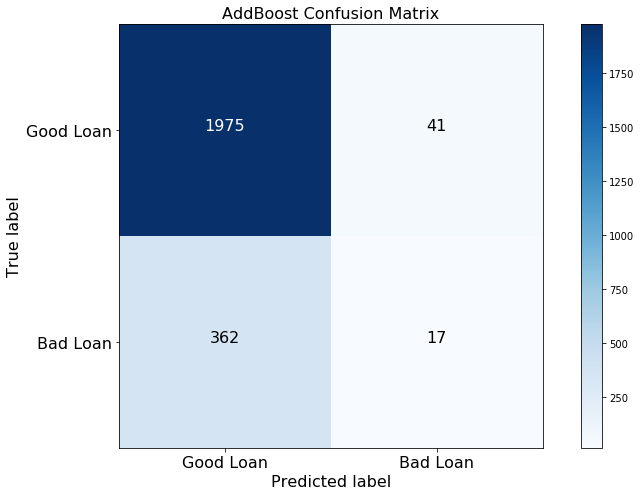

In [56]:
# Plot confusion matrix
y_pred = ab_sm.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(11,7))
plot_confusion_matrix(cnf_matrix, classes=["Good Loan", "Bad Loan"], normalize=False,
                      title='AddBoost Confusion Matrix')

plt.show()

### Neural Network

<b> Raw training set </b>

In [57]:
X_train_arr = X_train.values
y_train_arr = to_categorical(y_train.values)
X_test_arr = X_test.values
y_test_arr = to_categorical(y_test.values)

In [58]:
H = 100 # number of nodes in the layer
input_dim = X_train.shape[1] # input dimension
output_dim = 2 # output dimension

nn = Sequential() # create sequential multi-layer perceptron

# layer 0, our hidden layer
nn.add(Dense(H, input_dim=input_dim, activation='relu'))

# layer 1, our hidden layer
nn.add(Dense(H, activation='relu'))               
    
# layer 2, our hidden layer
nn.add(Dense(H, activation='relu'))

# layer 3
nn.add(Dense(output_dim, activation='sigmoid')) 

# compile the model
nn.compile(loss='binary_crossentropy', optimizer='sgd')
nn.summary()

epochs = 1000 
batch_size = 128
validation_split = 0.5

nn_history = nn.fit(X_train_arr, y_train_arr, 
                    batch_size=batch_size, 
                    epochs=epochs, verbose=False, 
                    shuffle = True, validation_data = (X_test_arr, y_test_arr))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               19500     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 39,902
Trainable params: 39,902
Non-trainable params: 0
_________________________________________________________________


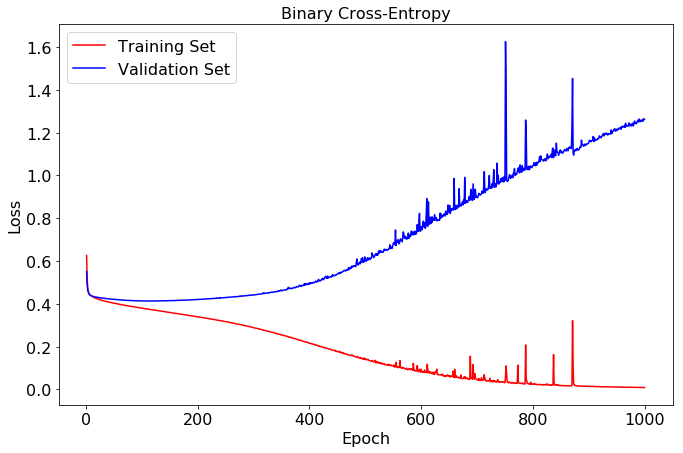

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(11,7))
ax.plot(range(1, epochs + 1), nn_history.history['loss'], 'r', label='Training Set')
ax.plot(range(1, epochs + 1), nn_history.history['val_loss'], 'b', label='Validation Set')
ax.set_title('Binary Cross-Entropy', fontsize=16)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.legend(fontsize=16)
ax.tick_params(labelsize=16)

In [60]:
H = 100 # number of nodes in the layer
input_dim = X_train.shape[1] # input dimension
output_dim = 2 # output dimension

nn = Sequential() # create sequential multi-layer perceptron

# layer 0, our hidden layer
nn.add(Dense(H, input_dim=input_dim, activation='relu'))

# layer 1, our hidden layer
nn.add(Dense(H, activation='relu'))               
    
# layer 2, our hidden layer
nn.add(Dense(H, activation='relu'))

# layer 3
nn.add(Dense(output_dim, activation='sigmoid')) 

# compile the model
nn.compile(loss='binary_crossentropy', optimizer='sgd')
nn.summary()

epochs = 160 
batch_size = 128

nn_history = nn.fit(X_train_arr, y_train_arr, 
                    batch_size=batch_size, 
                    epochs=epochs, verbose=False, 
                    shuffle = True, validation_data = (X_test_arr, y_test_arr))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               19500     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 202       
Total params: 39,902
Trainable params: 39,902
Non-trainable params: 0
_________________________________________________________________


In [61]:
nn_train_df = pd.DataFrame(nn.predict(X_train_arr))
nn_train_df['pred'] = nn_train_df.apply(lambda x: 1 if x[0] < x[1] else 0, axis=1)
nn_train_acc = accuracy_score(y_train, nn_train_df['pred'].values)

nn_test_df = pd.DataFrame(nn.predict(X_test_arr))
nn_test_df['pred'] = nn_test_df.apply(lambda x: 1 if x[0] < x[1] else 0, axis=1)
nn_test_acc = accuracy_score(y_test, nn_test_df['pred'].values)

report_lr = precision_recall_fscore_support(y_test, nn_test_df['pred'], average='binary')

nn_results = {
    'model': 'Neural Network',
    'train_acc': nn_train_acc,
    'test_acc': nn_test_acc,
    'precesion': report_lr[0],
    'recall': report_lr[1],
    'F1': report_lr[2]
}

print('Neural Network: accuracy on train={:.2%}, test={:.2%}, precision={:.2f}, recall={:.2f}, F1={:.2f}'.
      format(nn_results['train_acc'], 
             nn_results['test_acc'], 
             nn_results['precesion'], 
             nn_results['recall'], 
             nn_results['F1']))

Neural Network: accuracy on train=85.67%, test=83.97%, precision=0.44, recall=0.05, F1=0.09


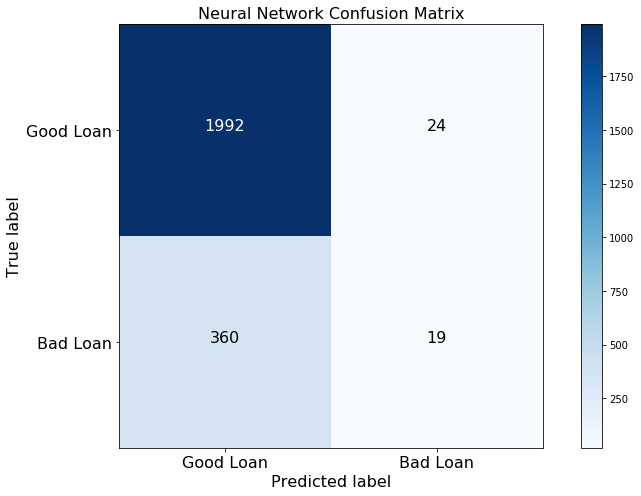

In [62]:
# Plot confusion matrix
cnf_matrix = confusion_matrix(y_test, nn_test_df['pred'].values)
np.set_printoptions(precision=2)

plt.figure(figsize=(11,7))
plot_confusion_matrix(cnf_matrix, classes=["Good Loan", "Bad Loan"], normalize=False,
                      title='Neural Network Confusion Matrix')

plt.show()

<b> Oversampled Training set </b>

In [63]:
X_train_arr = X_train_sm
y_train_arr = to_categorical(y_train_sm)
X_test_arr = X_test.values
y_test_arr = to_categorical(y_test.values)

In [64]:
H = 100 # number of nodes in the layer
input_dim = X_train_sm.shape[1] # input dimension
output_dim = 2 # output dimension

nn = Sequential() # create sequential multi-layer perceptron

# layer 0, our hidden layer
nn.add(Dense(H, input_dim=input_dim, activation='relu'))

# layer 1, our hidden layer
nn.add(Dense(H, activation='relu'))               
    
# layer 2, our hidden layer
nn.add(Dense(H, activation='relu'))

# layer 3
nn.add(Dense(output_dim, activation='sigmoid')) 

# compile the model
nn.compile(loss='binary_crossentropy', optimizer='sgd')
nn.summary()

epochs = 1000 
batch_size = 128
validation_split = 0.5

nn_history = nn.fit(X_train_arr, y_train_arr, 
                    batch_size=batch_size, 
                    epochs=epochs, verbose=False, 
                    shuffle = True, validation_data = (X_test_arr, y_test_arr))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               19500     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 202       
Total params: 39,902
Trainable params: 39,902
Non-trainable params: 0
_________________________________________________________________


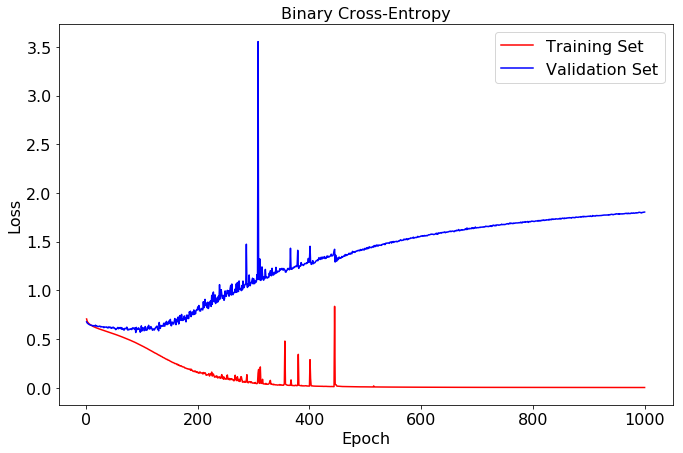

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(11,7))
ax.plot(range(1, epochs + 1), nn_history.history['loss'], 'r', label='Training Set')
ax.plot(range(1, epochs + 1), nn_history.history['val_loss'], 'b', label='Validation Set')
ax.set_title('Binary Cross-Entropy', fontsize=16)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.legend(fontsize=16)
ax.tick_params(labelsize=16)

In [66]:
H = 100 # number of nodes in the layer
input_dim = X_train_sm.shape[1] # input dimension
output_dim = 2 # output dimension

nn_sm = Sequential() # create sequential multi-layer perceptron

# layer 0, our hidden layer
nn_sm.add(Dense(H, input_dim=input_dim, activation='relu'))

# layer 1, our hidden layer
nn_sm.add(Dense(H, activation='relu'))               
    
# layer 2, our hidden layer
nn_sm.add(Dense(H, activation='relu'))

# layer 3
nn_sm.add(Dense(output_dim, activation='sigmoid')) 

# compile the model
nn_sm.compile(loss='binary_crossentropy', optimizer='sgd')
nn_sm.summary()

epochs = 1000 
batch_size = 128

nn_sm_history = nn_sm.fit(X_train_arr, y_train_arr, 
                          batch_size=batch_size, 
                          epochs=epochs, verbose=False, 
                          shuffle = True, validation_data = (X_test_arr, y_test_arr))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 100)               19500     
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_15 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 202       
Total params: 39,902
Trainable params: 39,902
Non-trainable params: 0
_________________________________________________________________


In [67]:
nn_train_df = pd.DataFrame(nn.predict(X_train_arr))
nn_train_df['pred'] = nn_train_df.apply(lambda x: 1 if x[0] < x[1] else 0, axis=1)
nn_train_acc = accuracy_score(y_train_sm, nn_train_df['pred'].values)

nn_test_df = pd.DataFrame(nn.predict(X_test_arr))
nn_test_df['pred'] = nn_test_df.apply(lambda x: 1 if x[0] < x[1] else 0, axis=1)
nn_test_acc = accuracy_score(y_test, nn_test_df['pred'].values)

report_lr = precision_recall_fscore_support(y_test, nn_test_df['pred'], average='binary')

nn_sm_results = {
    'model': 'Neural Network',
    'train_acc': nn_train_acc,
    'test_acc': nn_test_acc,
    'precesion': report_lr[0],
    'recall': report_lr[1],
    'F1': report_lr[2]
}

print('Neural Network: accuracy on train={:.2%}, test={:.2%}, precision={:.2f}, recall={:.2f}, F1={:.2f}'.
      format(nn_sm_results['train_acc'], 
             nn_sm_results['test_acc'], 
             nn_sm_results['precesion'], 
             nn_sm_results['recall'], 
             nn_sm_results['F1']))

Neural Network: accuracy on train=100.00%, test=75.74%, precision=0.23, recall=0.23, F1=0.23


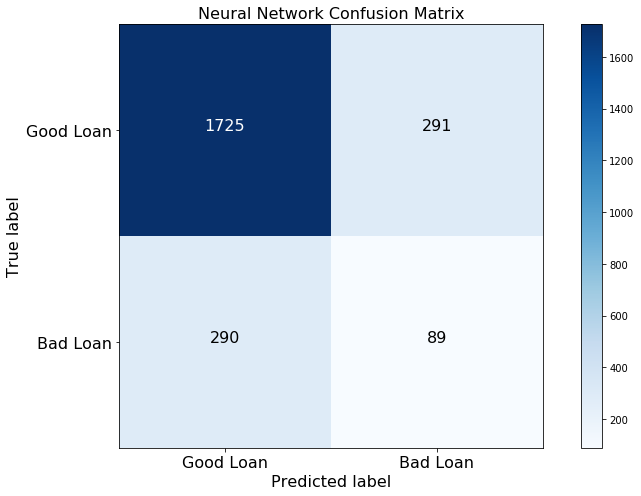

In [68]:
# Plot confusion matrix
cnf_matrix = confusion_matrix(y_test, nn_test_df['pred'].values)
np.set_printoptions(precision=2)

plt.figure(figsize=(11,7))
plot_confusion_matrix(cnf_matrix, classes=["Good Loan", "Bad Loan"], normalize=False,
                      title='Neural Network Confusion Matrix')

plt.show()

## Output Model Results

In [87]:
# Output results 
results = pd.DataFrame([logit_results, 
                        knn_results, 
                        lda_results, 
                        qda_results, 
                        tree_results, 
                        rf_results, 
                        ab_results, 
                        nn_results])
results.set_index('model', inplace=True)
results.to_csv("data/results.csv", index=True)

In [88]:
# Output results 
results_sm = pd.DataFrame([logit_sm_results, 
                           knn_sm_results, 
                           lda_sm_results, 
                           qda_sm_results, 
                           tree_sm_results, 
                           rf_sm_results, 
                           ab_sm_results, 
                           nn_sm_results])
results_sm.set_index('model', inplace=True)
results_sm.to_csv("data/results_sm.csv", index=True)